# **Прогнозирование факта невыполнения обязательств по кредиту**

На основании имеющихся данных о клиентах банка требуется построить модель для прогнозирования невыполнения долговых обязательств по текущему кредиту.

Целевая переменная 'Credit Default' - факт невыполнения кредитных обязательств. Необходимо использовать метрику качества F1-score (sklearn.metrics.f1_score).

Требования к решению:
- F1 > 0.5 по качеству прогноза для главного класса (1 - просрочка по кредиту);
- проанализировать один из признаков в разрезе целевой переменной.




# Загрузка и подготовка данных
<a id="s1"></a>

Импортируем необходимые библиотеки.

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.9 MB/s eta 0:00:00


In [ ]:
import catboost as catb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from imblearn.over_sampling import SMOTENC
from scipy.stats import ks_2samp, mannwhitneyu, probplot, shapiro
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import classification_report, f1_score, precision_score, precision_recall_curve, recall_score
from sklearn.model_selection import KFold, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")

Создадим функцию для вывода оценки метрик presicion, recall и F1.

In [ ]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

Создадим функцию для определения лучшего порога классификации.

In [ ]:
def thresholds_search(y, preds_proba):
  precision, recall, thresholds = precision_recall_curve(y.values, preds_proba)
  fscore = (2 * precision * recall) / (precision + recall)
  ix = np.argmax(fscore)
  threshold = thresholds[ix]
  fscore = fscore[ix]
  precision = precision[ix]
  recall = recall[ix]
  return threshold, fscore, precision, recall

Создадим функцию для расчета взаимной информации, чтобы определить влияние признаков на целевую переменную.

In [ ]:
def show_mutual_information(df, target = 'Credit Default'):
  all_features = df.drop('Credit Default', axis=1).columns.to_list()
  num_features = df.select_dtypes(include=['float64', 'int64']).drop('Credit Default', axis=1).columns.to_list()
  cat_features = df.select_dtypes(include=['object']).columns.to_list()

  temp_df = df.copy()
  for col in cat_features:
      temp_df[col] = temp_df[col].astype('category').cat.codes

  mi_scores = mutual_info_classif(temp_df.drop('Credit Default', axis=1), df[target], discrete_features=True)
  mi_series = pd.Series(mi_scores, index=all_features).sort_values(ascending=False)

  sns.barplot(x=mi_series.values, y=mi_series.index, palette = 'crest')
  plt.ylabel('')
  plt.title('Mutual Information with target variable')
  plt.show()

Просмотрим несколько строк датасета.

In [ ]:
df = pd.read_csv("credit_score.csv")
df.head(10)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
5,Rent,NaN,7 years,0.0,12.0,14.6,366784.0,0.0,NaN,0.0,other,Long Term,337304.0,165680.0,18692.0,NaN,1
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,Short Term,99999999.0,51623.0,2317.0,745.0,0
7,Rent,1040060.0,10+ years,0.0,13.0,12.0,330374.0,0.0,18.0,0.0,other,Short Term,250888.0,89015.0,19761.0,705.0,1
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,0.0,1.0,NaN,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0
9,Home Mortgage,NaN,1 year,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,debt consolidation,Long Term,572880.0,205333.0,17613.0,NaN,1


**Признаки:**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - кредитный рейтинг

**Целевой признак:**
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

Выведем информацию о датасете.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

Датасет содержит 7500 объектов и 17 признаков, как количественных, так и категориальных. Видим, что несколько столбцов содержат пропущенные значения.



## Анализ числовых признаков

Выведем информацию о количественных переменных.

In [ ]:
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


Построим корреляционную матрицу.

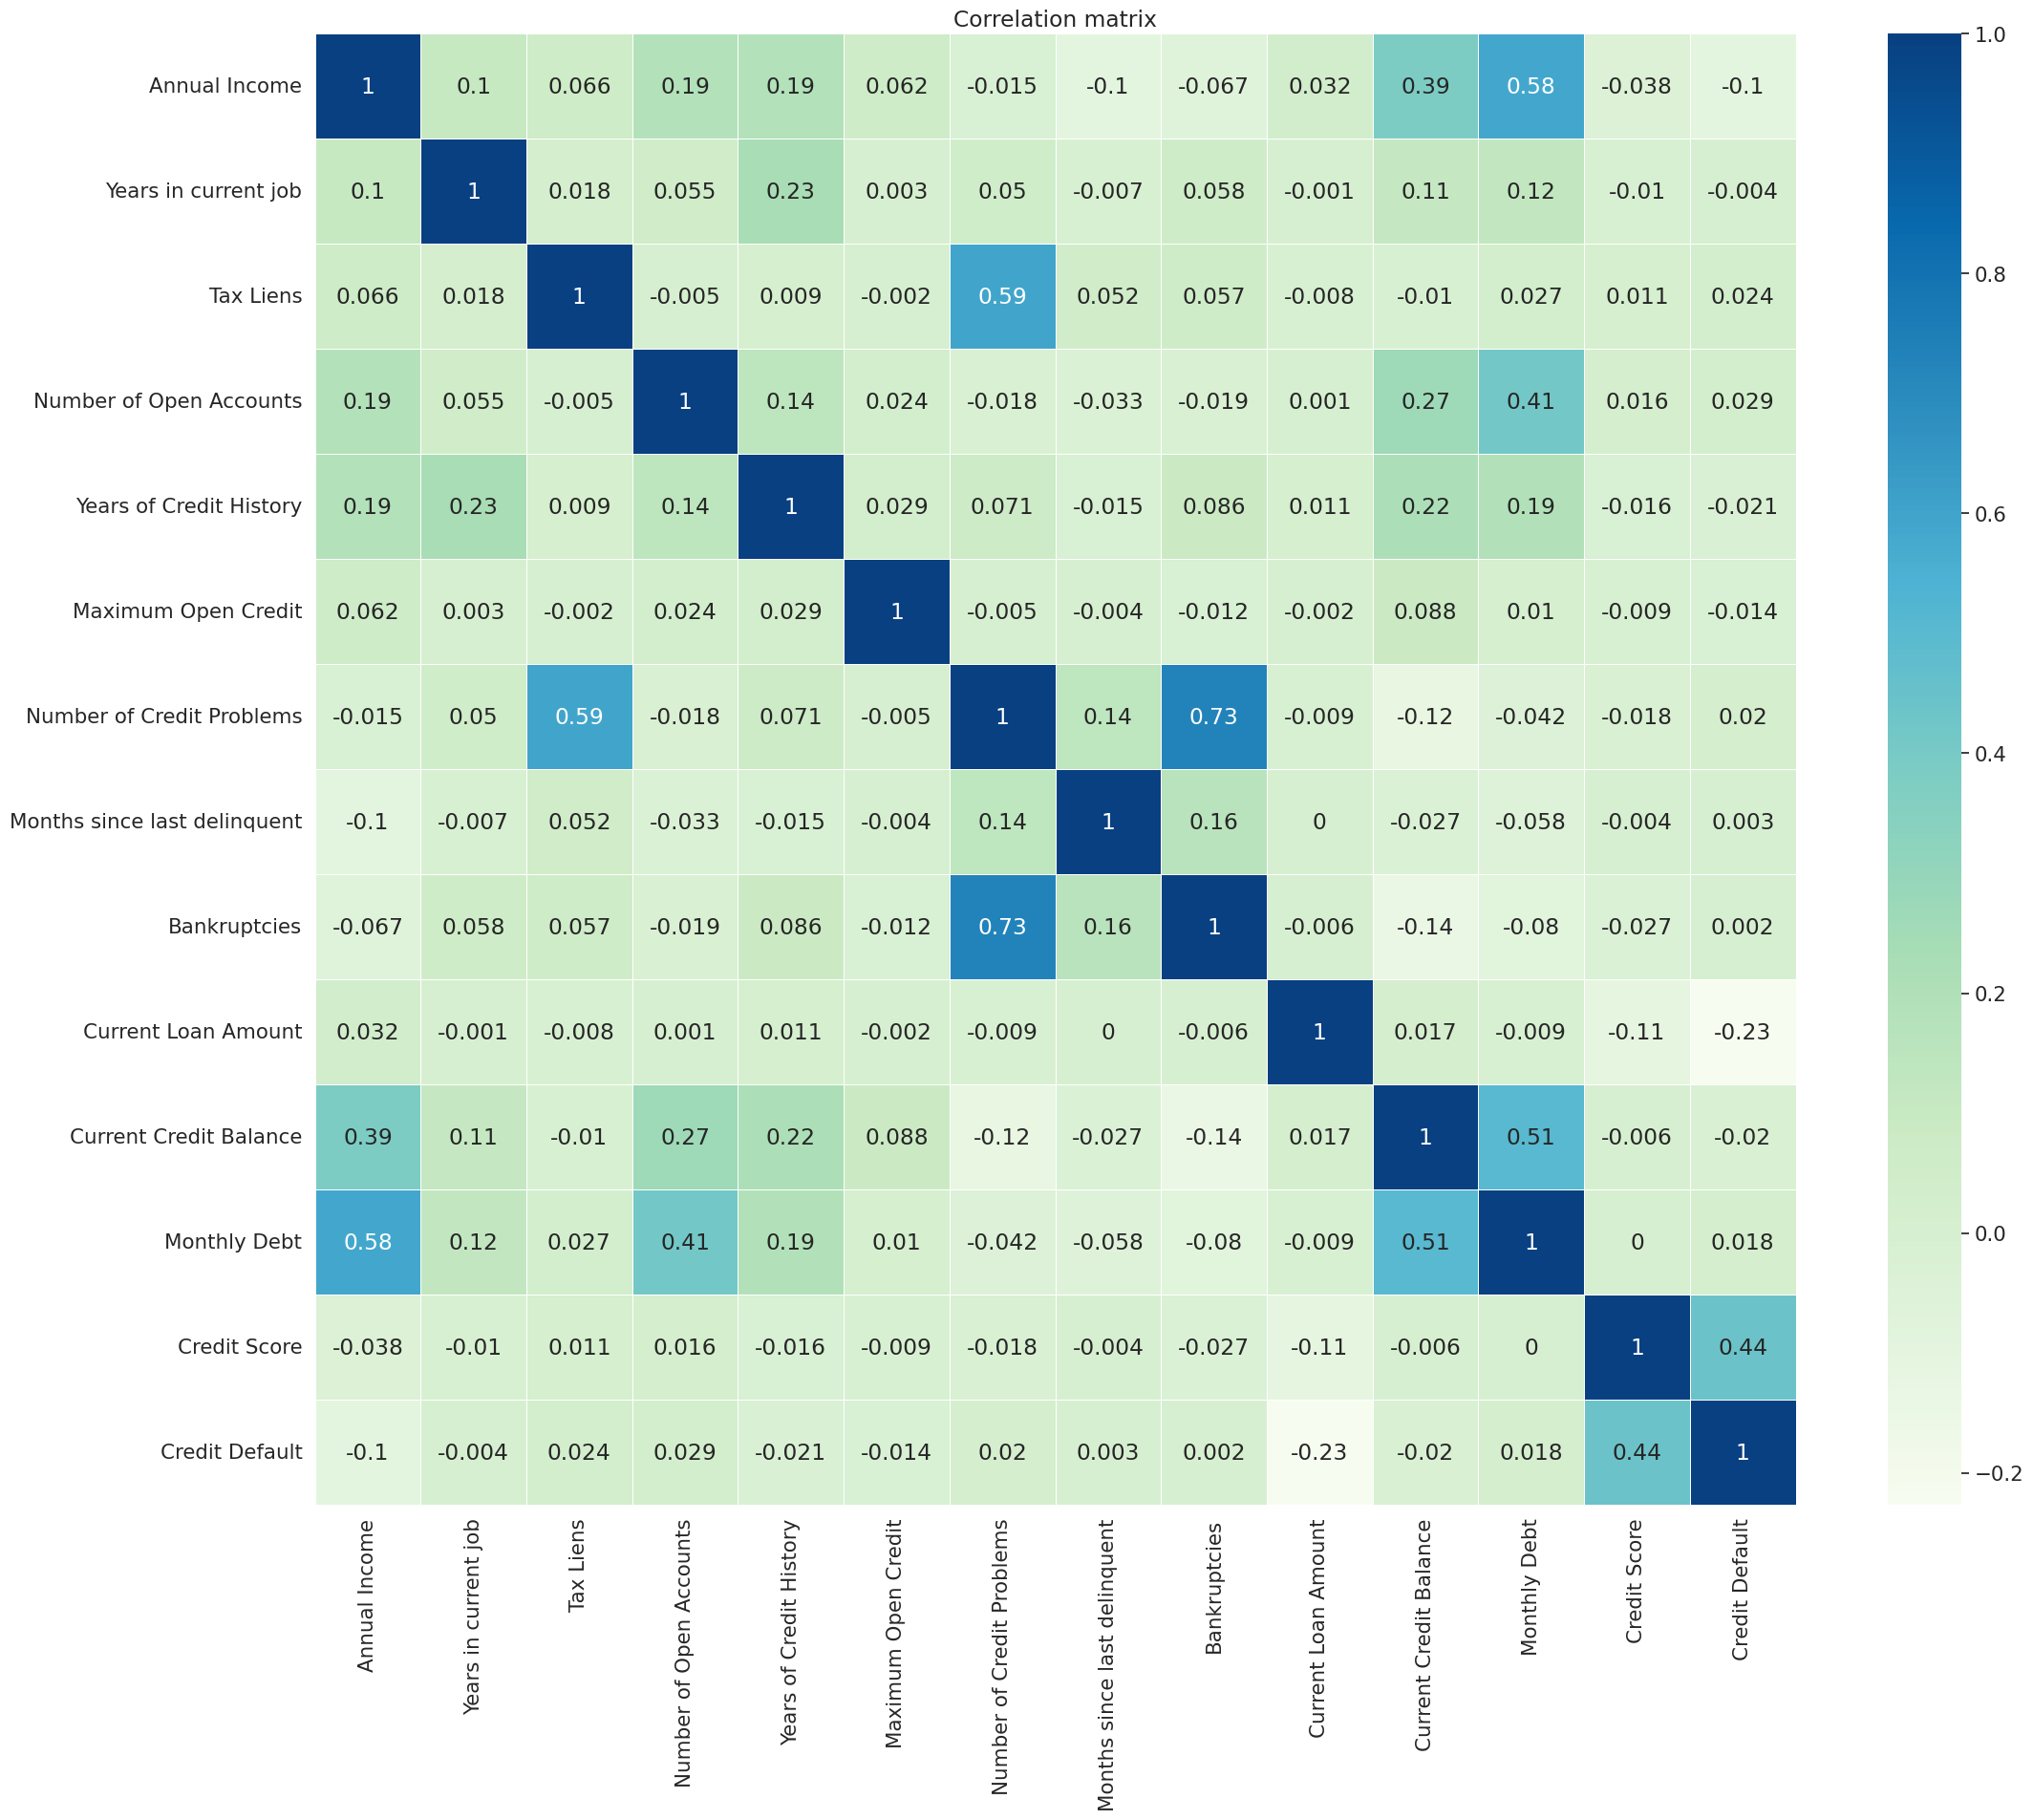

In [ ]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(df.select_dtypes(include=['float64', 'int64']).corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

Наибольшая корреляция целевой переменной наблюдается с 'Credit Score' - кредитный рейтинг. Также существуют связи между переменными 'Annual Income' и 'Monthly Debt', 'Annual Income' и 'Current Credit Balance', 'Tax Liens' и 'Number of Credit Problems', 'Number of Credit Problems' и 'Bankruptcies', 'Monthly Debt' и 'Current Credit Balance'.



## Анализ категориальных признаков

Выведем информацию о категориальных переменных.

In [ ]:
df.describe(include='object')

,Home Ownership,Years in current job,Purpose,Term
count,7500,7129,7500,7500
unique,4,11,15,2
top,Home Mortgage,10+ years,debt consolidation,Short Term
freq,3637,2332,5944,5556


Выведем значения категориальных столбцов и посмотрим, как их можно преобразовать.

In [ ]:
for col in df.select_dtypes(include='object').columns:
    print(f"{str(col)}\n\n{str(df[col].value_counts())}\n{'*' * 100}\n")

Home Ownership

Home Ownership
Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: count, dtype: int64
****************************************************************************************************

Years in current job

Years in current job
10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: count, dtype: int64
****************************************************************************************************

Purpose

Purpose
debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expense

В столбце 'Home Ownership' есть два похожих значения, связанных с ипотечными обязательствами: 'Home Mortgage' и 'Have Mortgage'. Значений 'Have Mortgage' всего 12. Преобразуем их в одно значение 'Mortgage'.

In [ ]:
df.loc[(df['Home Ownership'] == 'Home Mortgage') |(df['Home Ownership'] == 'Have Mortgage'), 'Home Ownership'] = 'Mortgage'

Преобразуем значения признака 'Years in current job' к целочисленным.

In [ ]:
year = {"< 1 year":  0,
        "1 year": 1,
        "2 years": 2,
        "3 years": 3,
        "4 years": 4,
        "5 years": 5,
        "6 years": 6,
        "7 years": 7,
        "8 years": 8,
        "9 years": 9,
        "10+ years": 10}

df['Years in current job'].replace(year, inplace=True)

Столбец целей кредитования содержит много значений, некоторые из которых похожи. Объединим их.

In [ ]:
df.loc[(df['Purpose'] == 'business loan') | (df['Purpose'] == 'small business'), 'Purpose'] = 'business'
df.loc[(df['Purpose'] == 'major purchase') |(df['Purpose'] == 'buy a car') | (df['Purpose'] == 'buy house'), 'Purpose'] = 'major purchase'
df.loc[(df['Purpose'] == 'take a trip') | (df['Purpose'] == 'vacation') | (df['Purpose'] == 'moving'), 'Purpose'] = 'trip'
df.loc[(df['Purpose'] == 'renewable energy') | (df['Purpose'] == 'wedding') | (df['Purpose'] == 'educational expenses'), 'Purpose'] = 'other'

## Обработка выбросов

Построим ящики с усами для отображения выбросов.

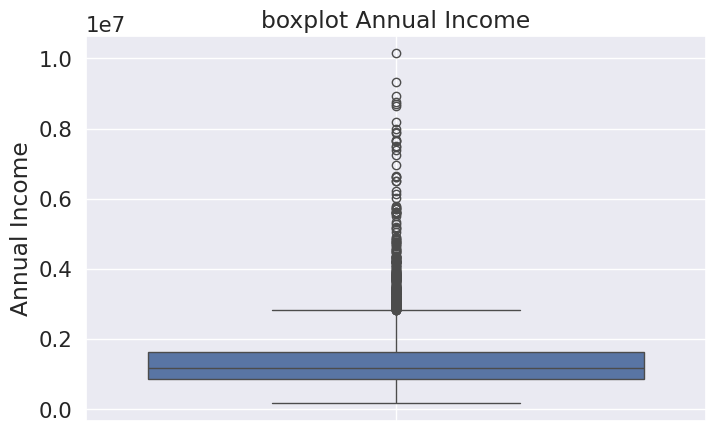

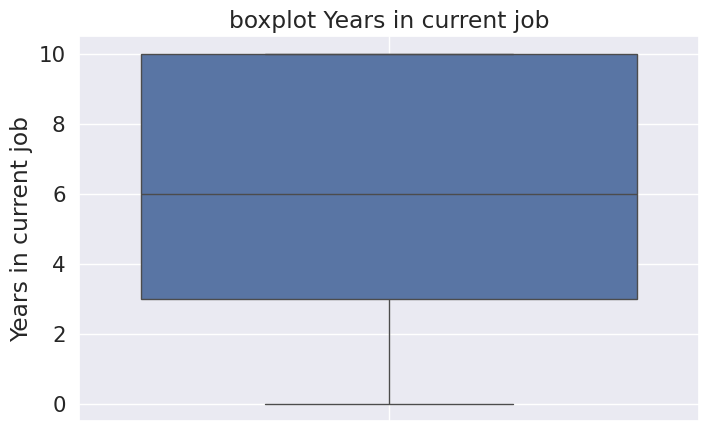

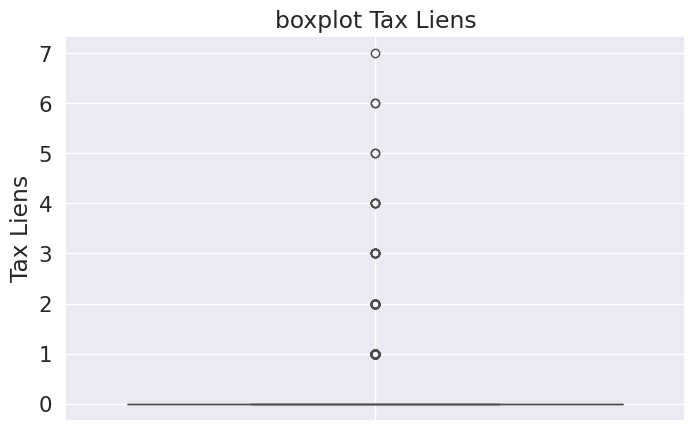

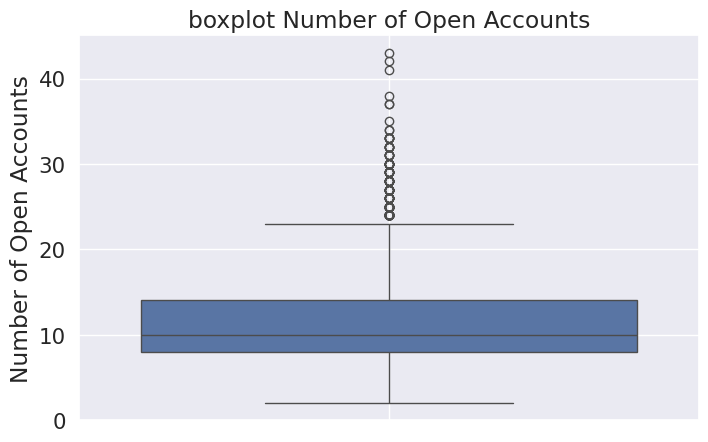

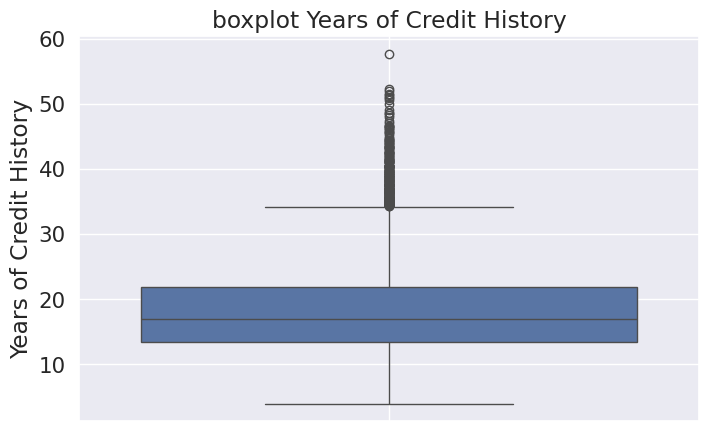

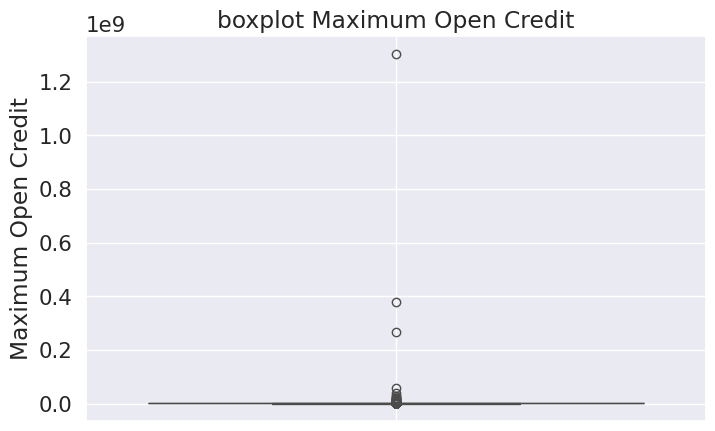

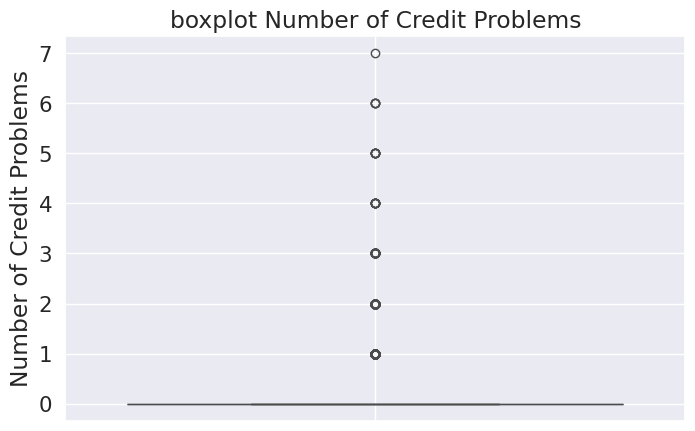

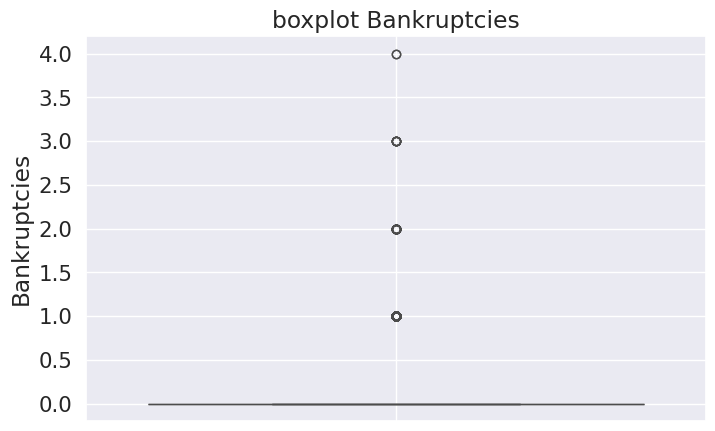

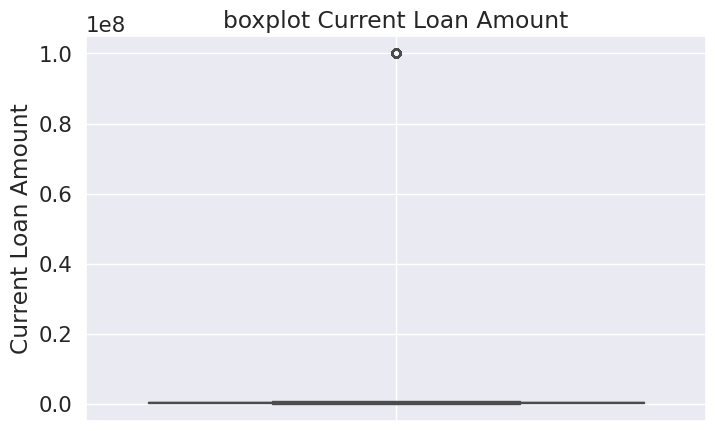

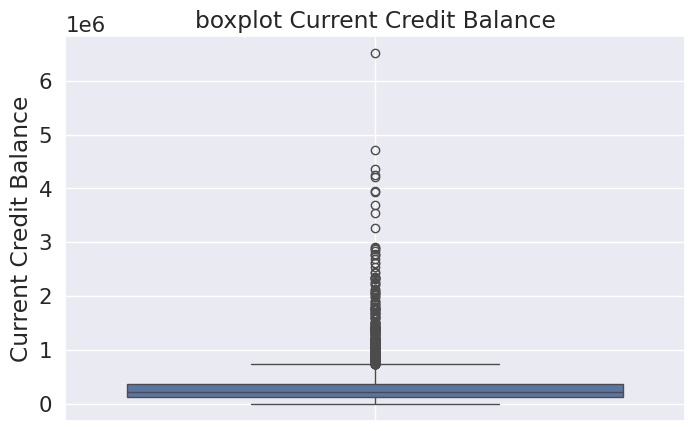

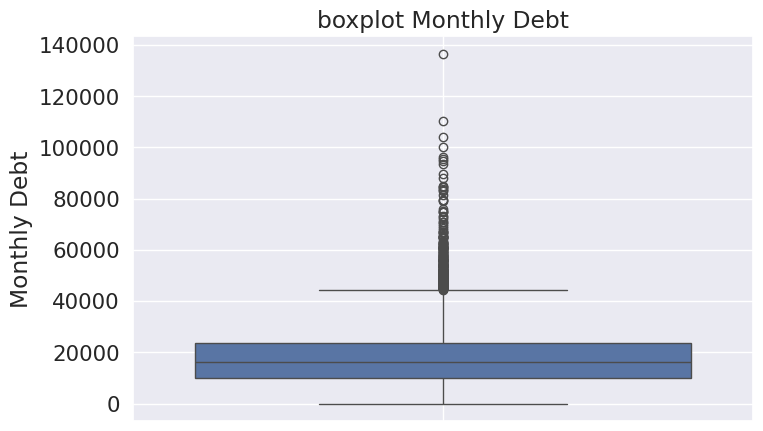

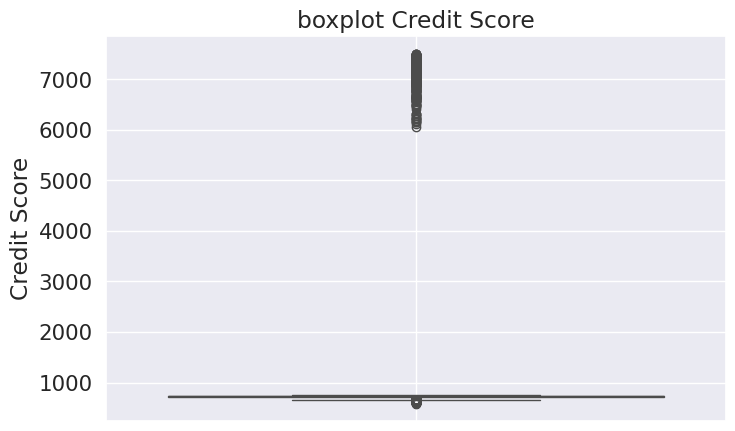

In [ ]:
for col in list(df.select_dtypes(include='float64').columns):
    plt.figure(figsize=(8, 5))
    sns.boxplot(df[col])
    plt.title(f'boxplot {col}')
    plt.grid(True)
    plt.show()

По некоторым графикам сложно сказать, какие значения являются выбросами. Построим диаграммы размаха скрыв точки, которые находятся за пределами усов: по умолчанию при построении диаграмм размаха используется правило '1.5 × IQR'.

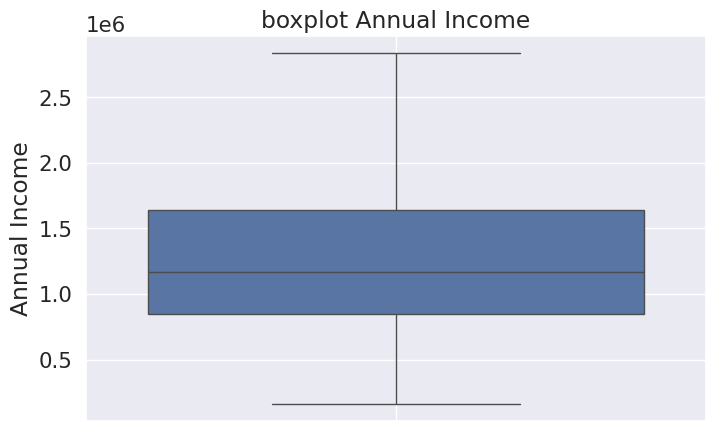

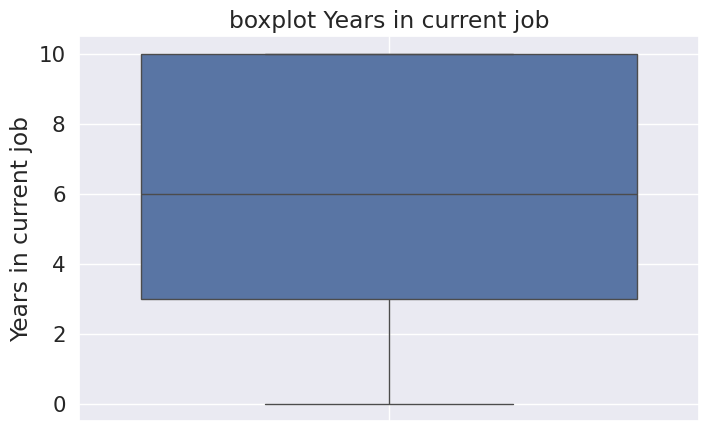

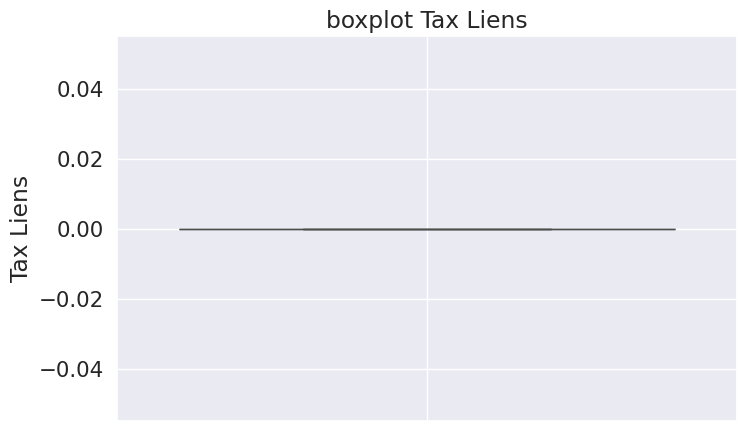

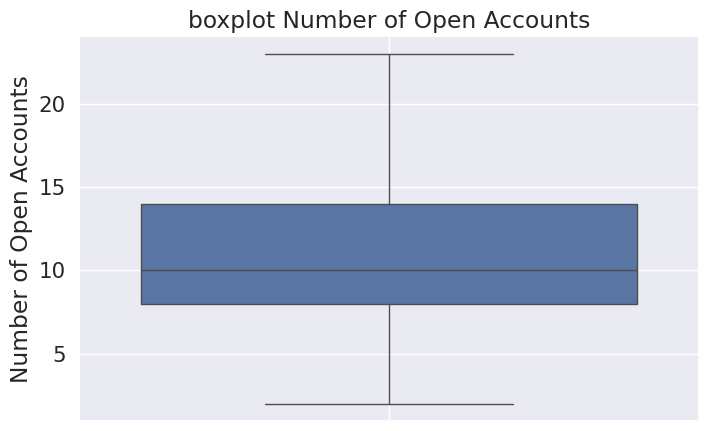

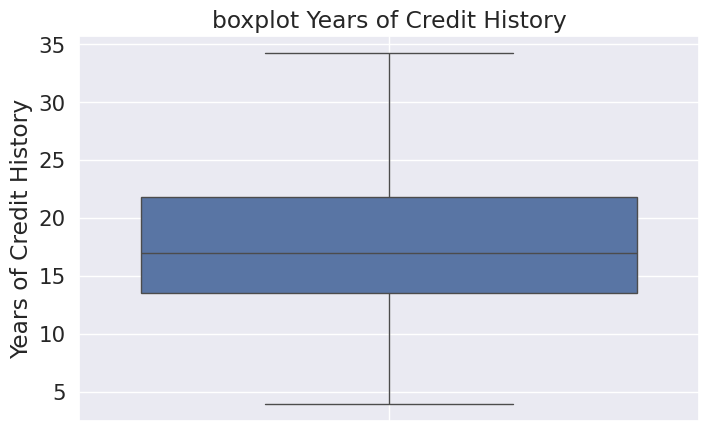

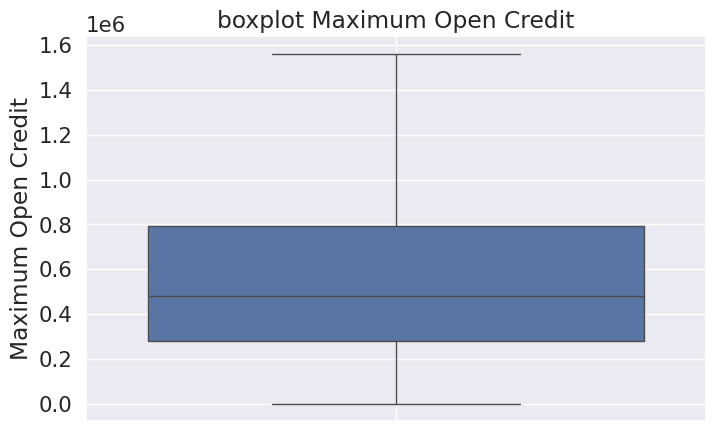

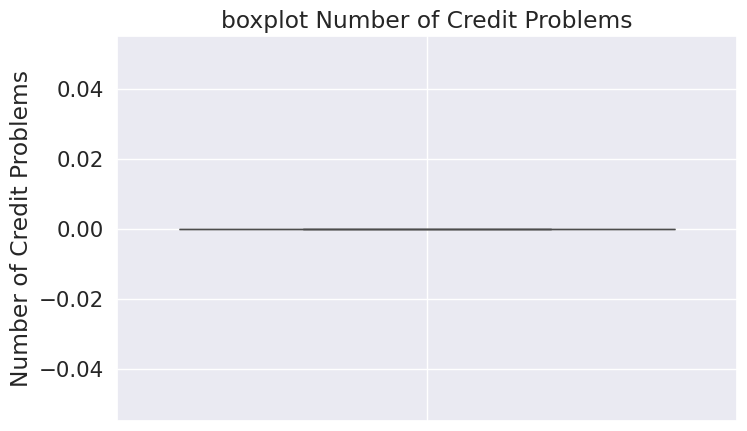

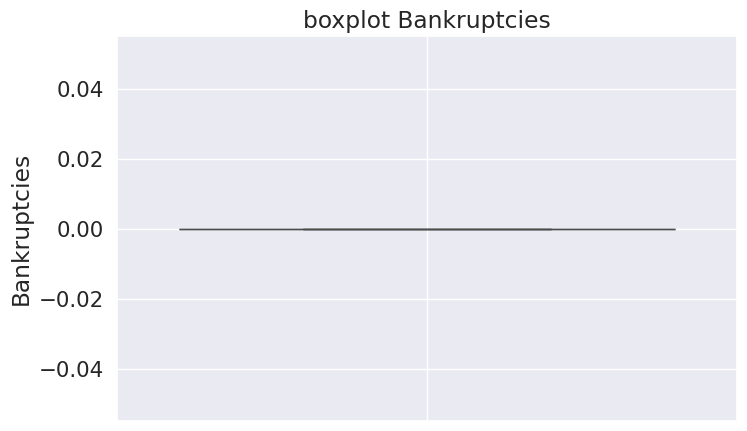

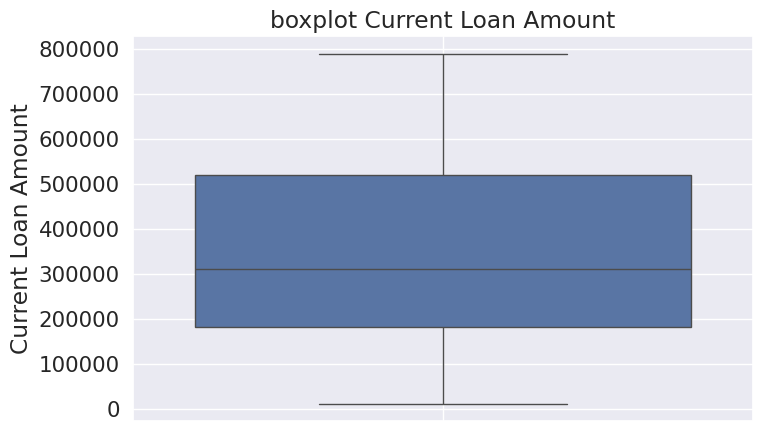

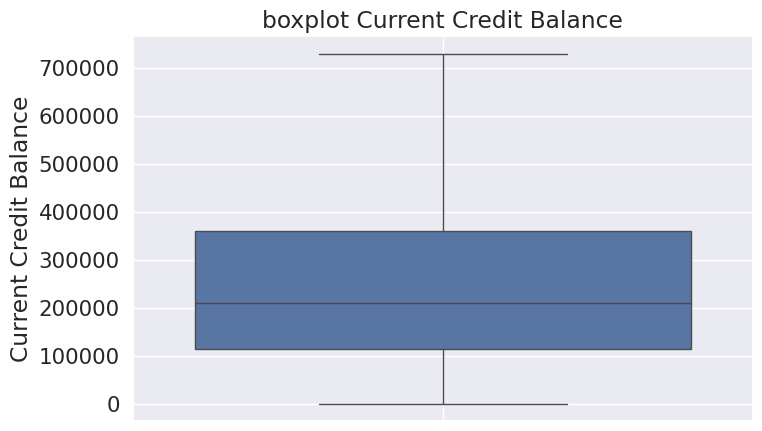

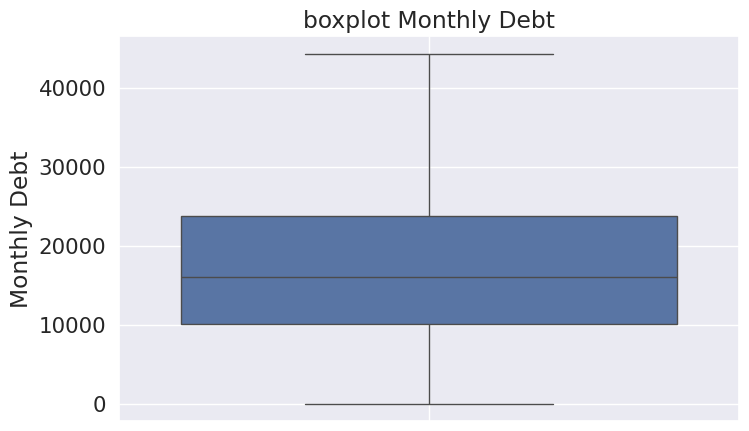

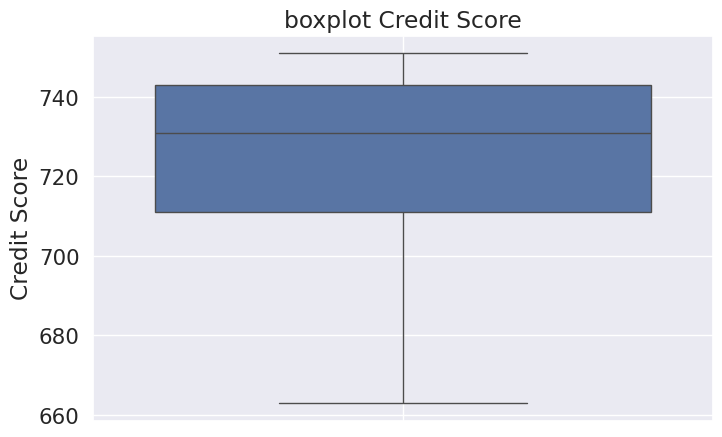

In [ ]:
for col in list(df.select_dtypes(include='float64').columns):
    plt.figure(figsize=(8, 5))
    sns.boxplot(df[col], showfliers=False)
    plt.title(f'boxplot {col}')
    plt.grid(True)
    plt.show()

**Выбросы по признакам:**

Annual Income: значения больше 300000.

Years in current job: выбросов нет.

Tax Liens: значения от 1 обозначены как выбросы. Рассмотрим этот признак чуть позже более подробно.

Number of Open Accounts: значения чуть больше 20.

Years of Credit History: значения около 35.

Maximum Open Credit: значения от 1600000.

Number of Credit Problems: значения от 1 обозначены как выбросы. Рассмотрим этот признак чуть позже более подробно.

Bankruptcies: значения от 1 обозначены как выбросы. Рассмотрим этот признак чуть позже более подробно.

Current Loan Amount: значения от 800000.

Current Credit Balance: значения от 700000.

Monthly Debt: значения от около 45000.

Credit Score: значения меньше 600 и больше 800.



Проверим количество значений в признаках 'Tax Liens', 'Number of Credit Problems' и 'Bankruptcies'.


In [ ]:
df['Tax Liens'].value_counts()

,count
Tax Liens,
0.0,7366
1.0,83
2.0,30
3.0,10
4.0,6
6.0,2
5.0,2
7.0,1


In [ ]:
df['Number of Credit Problems'].value_counts()

,count
Number of Credit Problems,
0.0,6469
1.0,882
2.0,93
3.0,35
4.0,9
5.0,7
6.0,4
7.0,1


In [ ]:
df['Bankruptcies'].value_counts()

,count
Bankruptcies,
0.0,6660
1.0,786
2.0,31
3.0,7
4.0,2


Эти признаки содержат много значений, которые можно интерпретировать как выбросы. Скорее всего, ненулевые значения несут в себе важную информацию, и их удаление из датасета может привести к ошибкам, так как исключит из анализа более редкие, но важные величины. Нами  были предприняты попытки заменить более высокие значения признаков на более низкие - чаще встречающиеся - но это привело к небольшому ухудшению метрик модели.

In [ ]:
# df.loc[df['Tax Liens'] >= 1, 'Tax Liens'] = 1
# df.loc[df['Number of Credit Problems'] >= 3, 'Number of Credit Problems'] = 3
# df.loc[df['Bankruptcies'] >= 2, 'Bankruptcies'] = 2

Заменим значение '99999999' в признаке 'Current Loan Amount', так как, скорее всего, оно ошибочно или является технической информацией.

In [ ]:
df['Is_999'] = (df['Current Loan Amount'] > 99000000)
df.loc[df['Current Loan Amount'] == 99999999, 'Current Loan Amount'] = df['Current Loan Amount'].max()

## Обработка пропусков

Выведем количество пропусков по столбцам.

In [ ]:
pd.concat([df.isna().sum(), df.isna().sum()/len(df)], axis=1, keys = ['count', 'proportion'])

,count,proportion
Home Ownership,0,0.000000
Annual Income,1557,0.207600
Years in current job,371,0.049467
Tax Liens,0,0.000000
Number of Open Accounts,0,0.000000
Years of Credit History,0,0.000000
Maximum Open Credit,0,0.000000
Number of Credit Problems,0,0.000000
Bankruptcies,14,0.001867
Purpose,0,0.000000


Больше половины значений в столбце 'Months since last delinquent' являются пропущенными. Проверим, как распределены пропуски по классам, так как количество месяцев с последней просрочки платежа может быть указано, например, только для класса с просроченными обязательствами.

In [ ]:
df.groupby('Credit Default').agg({'Months since last delinquent': 'count'})

,Months since last delinquent
Credit Default,
0,2436
1,983


Пропуски содержаться в обоих классах. Вероятно, наилучшим решением будет удаление признака, так он содержит мало полезной информации. Также по матрице корреляций этот признак почти не коррелирует с целевой переменной.

In [ ]:
df.drop('Months since last delinquent', axis=1, inplace=True)

В столбцах 'Annual Income' и 'Credit Score' около 20% пропусков, что тоже много. И наименьшее количество пропусков в столбцах 'Years in current job' и 'Bankruptcies'. Попробуем заполнить пропущенные значения медианой, сгруппировав данные по категориальным признакам (это даст более точную оценку дохода), так как медиана достаточно устойчива к выбросам.


In [ ]:
for col in df.columns[df.isna().any()].tolist():
  df[col].fillna(df.groupby(['Home Ownership', 'Purpose'])[col].transform('median'), inplace=True)

Заменим вещественные значения 'Years in current job' на целые.

In [ ]:
df.loc[(df['Years in current job'] == 6.5), 'Years in current job'] = 6.0
df.loc[(df['Years in current job'] == 7.5), 'Years in current job'] = 7.0

In [ ]:
df.isna().sum()

,0
Home Ownership,0
Annual Income,0
Years in current job,0
Tax Liens,0
Number of Open Accounts,0
Years of Credit History,0
Maximum Open Credit,0
Number of Credit Problems,0
Bankruptcies,0
Purpose,0


Пропусков нет.

# Анализ целевого признака

Целевой признак представляет собой бинарную переменную.  Проверим, насколько сбалансированы классы: выведем количество объектов 0 и 1 класса, а также их процентное соотношение в наборе данных.

In [ ]:
pd.concat([df['Credit Default'].value_counts(), df['Credit Default'].value_counts(normalize=True)], axis=1)

,count,proportion
Credit Default,,
0,5387,0.718267
1,2113,0.281733


Визуализируем для удобства восприятия.

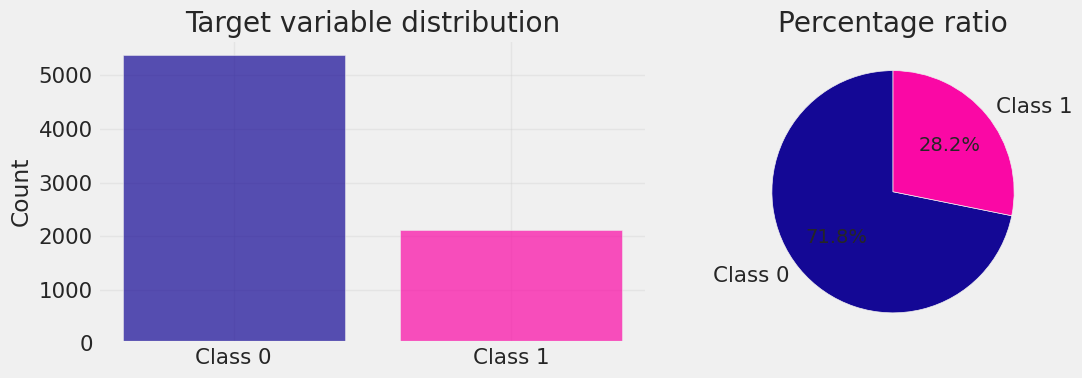

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].bar(['Class 0', 'Class 1'],
            [sum(df['Credit Default'] == 0),
            sum(df['Credit Default'] == 1)],
            color=['#140895', '#FA08A5'],
            alpha=0.7)
axes[0].set_title('Target variable distribution')
axes[0].set_ylabel('Count')
axes[0].grid(alpha=0.3)

axes[1].pie([sum(df['Credit Default'] == 0), sum(df['Credit Default'] == 1)],
            labels=['Class 0', 'Class 1'],
            autopct='%1.1f%%',
            colors=['#140895', '#FA08A5'],
            startangle=90)
axes[1].set_title('Percentage ratio')

plt.tight_layout()
plt.show()

Наблюдается проблема дисбаланса классов. Попробуем решить проблему при помощи следующих методов:
- Использование встроенного параметра auto_class_weights="Balanced" алгоритма CatBoostClassifier. Он автоматически вычисляет веса классов на основе частот классов в обучающих данных. Этот параметр подходит для исследуемых данных - датасета с очень ощутимым дисбалансом.
- Использование алгоритма SMOTENC – версии алгоритма SMOTE для смешанных данных - метод балансировки данных, который генерирует новые примеры меньшинства на основе ближайших соседей этих случаев. Это повышает качество классификации без простого дублирования существующих данных как при обычном оверсэмплинге.

# Влияние признаков на целевую переменную

Проверим влияние признаков на целевую переменную при помощи взаимной информации, так как метод может измерить любую статистическую зависимость (включая нелинейные и немонотонные связи), в отличие от корреляции, которая обнаруживает только линейные зависимости.

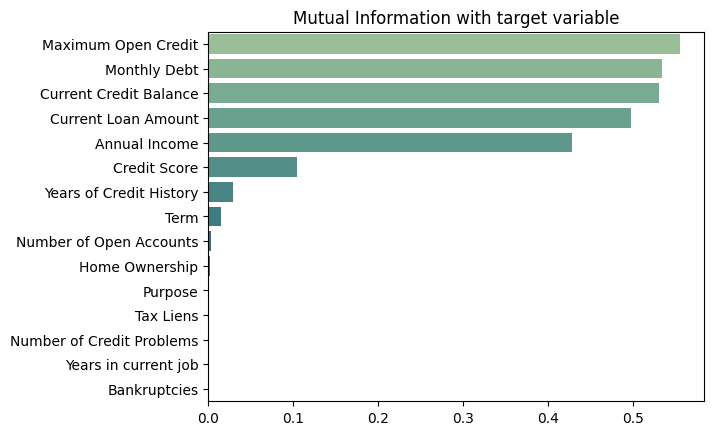

In [ ]:
show_mutual_information(df)

Наибольшее значение на целевую переменную оказывают влияние признаки:  наибольший открытый кредит, ежемесячный долг, текущий кредитный баланс, текущая сумма кредита, годовой доход. По длине столбца можем сопоставить силу влияния. Кредитный рейтинг в отличие от матрицы корреляций располагается шестым по счету – это значит, что связь этого признака с целевым линейна, но в ней меньше полезной информации, чем в других признаках.

# Анализ признака "Credit Score" в разрезе целевой переменной

Выполним статистический анализ признака Credit Score, чтобы понять, будет ли он важным при построении модели.

Мы видим, что признак имеет достаточно высокий показатель корреляции с целевой переменной (0.44), но по взаимной информации занимает только 6 место. Анализ Credit Score поможет понять, действительно ли он является важным предиктором или дублирует информацию других переменных, но в более удобном для корреляции (линейном) виде.


Построим график распределения для клиентов, допустивших и не допустивших невыполнение обязательств по кредиту. Выберем 1000 случайных объектов, их будет достаточно для оценки.

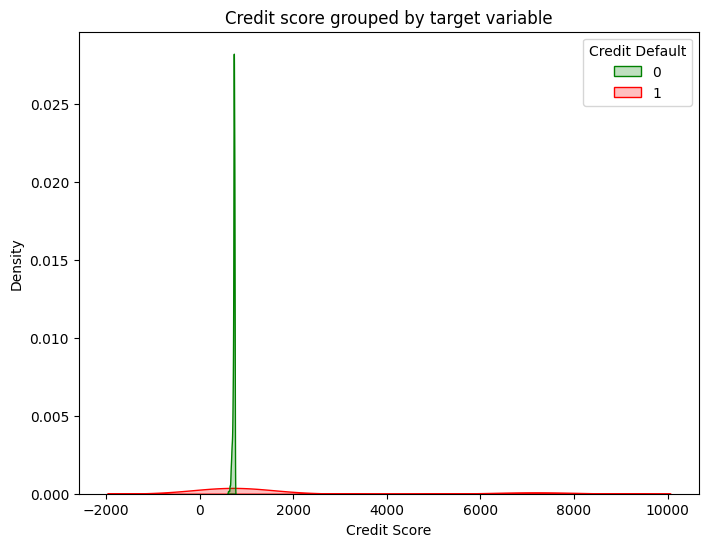

In [ ]:
credit_score_with_target = df[['Credit Score', 'Credit Default']].sample(1000)

plt.figure(figsize=(8, 6))

sns.kdeplot(data=credit_score_with_target, x='Credit Score', hue='Credit Default', fill=True, common_norm=False, palette=['g', 'r'])

plt.xlabel('Credit Score')
plt.title('Credit score grouped by target variable')
plt.show()

In [ ]:
credit_score_with_target['Credit Default'].value_counts()

,count
Credit Default,
0,714
1,286


**Наблюдение**

Распределения имеют различную форму, значит, признак значим для построения модели. Если бы признак никак не влиял на целевую переменную, то распределение было бы одинаковым для любого значения. Если распределения разные, значит, признак ведет себя по-разному в зависимости от значения таргета.

Распределение для 0 класса представляет вытянутый холм, что может говорить об однородности группы надежных заемщиков: есть четкое значение кредитного рейтинга, вокруг которого сосредоточено большинство людей. Для 1 класса распределение представляет собой два холма (бимодальное), что указывает на неоднородность и высокую дисперсию. Бимодальность может указывать на существование двух видов неблагонадежных заемщиков: заемщики с низким и высоким рейтингом. Первые могут являться изначально неблагонадежными. Вторые могут иметь высокий рейтинг, но все равно не вернуть кредит: возможно, это мошенничество или резко изменившиеся жизненные обстоятельства, которые не успели отразиться на рейтинге. Плоское распределение может указывать на то, что 'Credit Score' сам по себе не является решающим фактором для невыполнения кредитных обязательств. Это значит, что люди с дефолтом могут встречаться при любом рейтинге.

Необходимо сравнить две выборки на равенство средних значений. Если вероятность того, что математические ожидания в исходных группах равны, при данных выборках, будет менее 5%, то можно будет говорить о том, что, скорее всего, выборки имеют различные распределения.

**Гипотеза**

* Нулевая гипотеза: средние значения в двух независимых выборках равны.
* Альтернативная гипотеза: средние значения в двух независимых выборках различаются.

При анализе графиков выявлено, что распределение не является нормальным. Для выбора критерия проверим нормальность дополнительно при помощи теста  Шапиро-Уилка:
* Нулевая гипотеза: данные распределены нормально.
* Альтернативная гипотеза: закон распределения не является нормальным.


In [ ]:
statistic, p_value = shapiro(credit_score_with_target)
print(f"Статистика Shapiro: {statistic:.4f}")
print(f"p-value: {p_value:.4e}")

Статистика Shapiro: 0.3576
p-value: 3.1679e-64


По полученному значению p-value, которое намного меньше 0.05, можем заключить, что гипотеза о "нормальности" отвергается.

Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график.

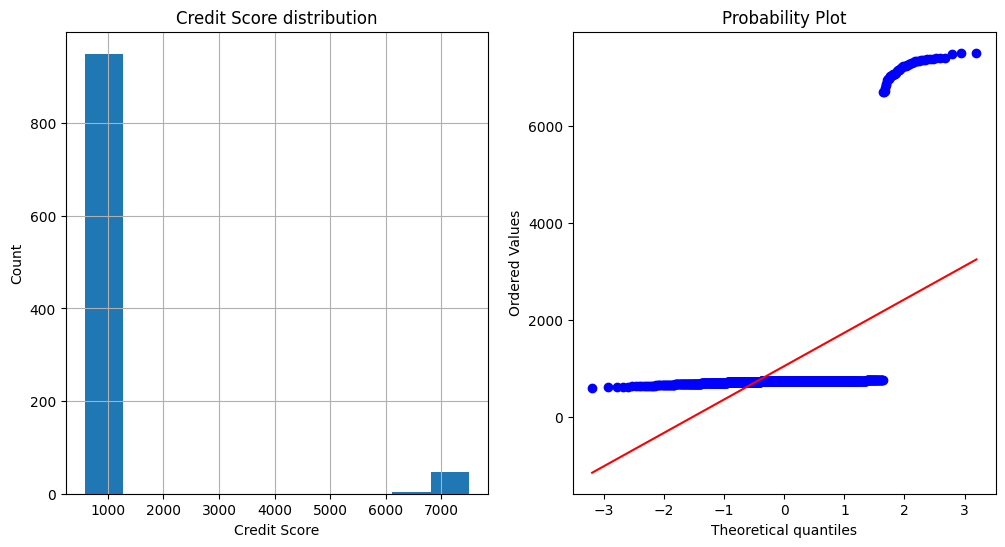

In [ ]:
plt.figure(figsize=(12, 6))

ax1 = plt.subplot(121)
ax1.set_xlabel('Credit Score')
ax1.set_ylabel('Count')
ax1.set_title('Credit Score distribution')
credit_score = credit_score_with_target['Credit Score']
credit_score.hist()

plt.subplot(122)
probplot(credit_score, dist='norm', plot=plt)

plt.show()



Критерий Стьюдента не может быть использован, так как распределение не является нормальным. Будем использовать непараметрический критерий Манна-Уитни.


In [ ]:
credit_default_0 = credit_score[credit_score_with_target['Credit Default'] == 0]
credit_default_1 = credit_score[credit_score_with_target['Credit Default'] == 1]

In [ ]:
statistic, p_value = mannwhitneyu(credit_default_0, credit_default_1)
print(f"Статистика Mann-Whitney: {statistic:.4f}")
print(f"p-value: {p_value:.4e}")

Статистика Mann-Whitney: 99015.5000
p-value: 4.5210e-01


Несмотря на корреляцию с целевой переменной (0.44),  тест Манна-Уитни не подтвердил разницу средних между группами (p=0.45). Это свидетельствует о немонотонном характере зависимости: значения класса 1 распределены бимодально, и левая часть распределения совпадает с распределением надежных заемщиков (класс 0). Признак крайне важен для моделирования, но требует использования нелинейных алгоритмов, так как классические тесты на различие средних не способны уловить структуру его влияния.

Для дополнительной проверки можем построить доверительные интервалы для средних значений и сравнить их.

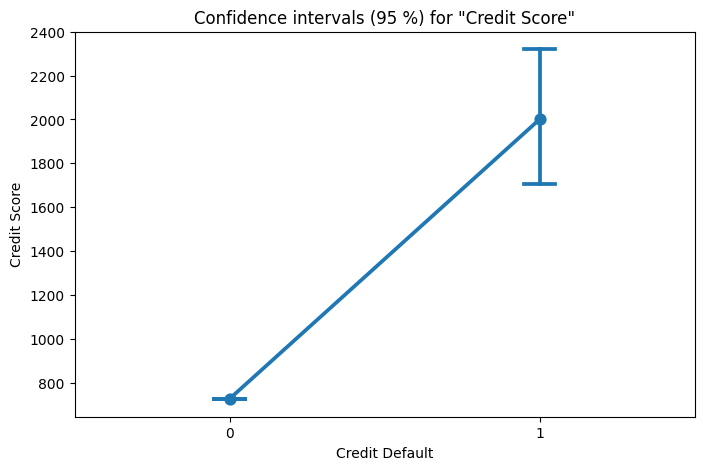

In [ ]:
plt.figure(figsize=(8, 5))

sns.pointplot(data=credit_score_with_target, x='Credit Default', y='Credit Score', capsize=.1)

plt.title('Confidence intervals (95 %) for "Credit Score"')
plt.show()

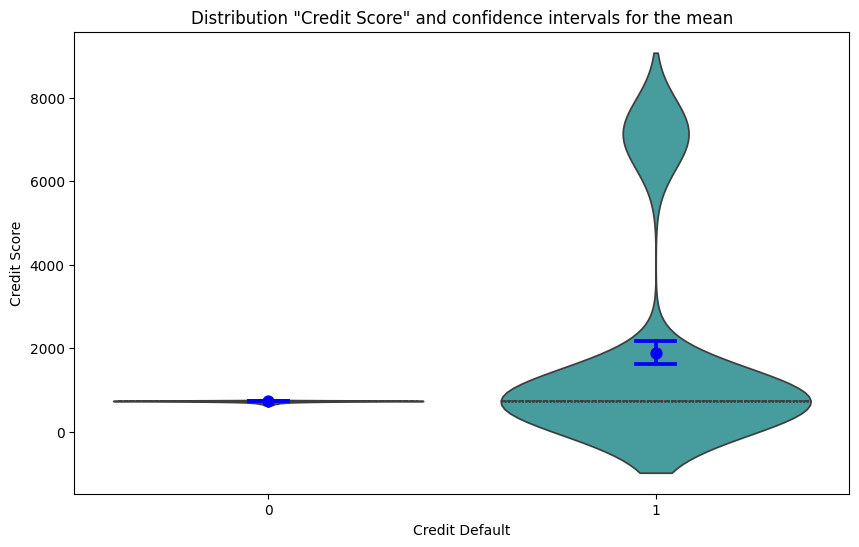

In [ ]:
plt.figure(figsize=(10, 6))

sns.violinplot(data=credit_score_with_target, x='Credit Default', y='Credit Score', palette='mako', inner="quart")
sns.pointplot(data=credit_score_with_target, x='Credit Default', y='Credit Score',
              errorbar='ci', color='blue', capsize=.1, linestyles='')

plt.title('Distribution "Credit Score" and confidence intervals for the mean')
plt.show()

На графиках изображены распределения и доверительные интервалы (95%) для 'Credit Score' в двух группах: 'Credit Default' = 0 и 'Credit Default' = 1.

Класс 0 имеет значительно более низкий средний кредитный рейтинг (около 600-700). Класс 1 имеет средний кредитный рейтинг около 1800 баллов. Интервалы не перекрываются, что статистически указывает на существенное различие средних значений 'Credit Score' между группами. Это вновь подтверждает, что признак является хорошим предиктором целевой переменной. Оба интервала достаточно узкие, что говорит о высокой точности оценок среднего значения в каждой группе. Интервал класса 1 немного шире, что может указывать на большую вариативность рейтинга среди клиентов с невыполнением кредитных обязательств или меньший размер подвыборки.

Подтверждается бимодальность распределения класса 1. Большое количество объектов с дефолтом располагается в нижней части и имеет более низкие значения кредитного рейтинга. В середине значений кредитного рейтинга объектов почти не наблюдается. И меньшее количество объектов с дефолтом располагается в верхней части  графика и имеет более высокие значения кредитного рейтинга. Это значит, что среднее значение кредитного рейтинга объектов 1 класса не отражает реальной картины.


Противоречие между результатом теста Манна-Уитни и средними значениями доверительных интервалов скорее всего связано с тем, что распределения имеют разную форму (скошенность, выбросы), разные дисперсии, содержат большое количество одинаковых значений (рангов).

Попробуем провести тест Колмогорова-Смирнова, чтобы оценить существенность различий между распределениями этих выборок, а не только между средними значениями. В данном случае этот тест является решающим, так как он, в отличие от Манна-Уитни, чувствителен к любым различиям в распределениях, включая форму, количество «холмов» и дисперсию, а не только к сдвигу среднего.

**Гипотеза**

* Нулевая гипотеза: выборки взяты из одного и того же распределения.
*	Альтернативная гипотеза: выборки принадлежат разным генеральным совокупностям.


In [ ]:
statistic, p_value = ks_2samp(credit_default_0, credit_default_1)
print(f"KS-статистика: {statistic:.4f}")
print(f"p-value: {p_value:.4e}")

KS-статистика: 0.1818
p-value: 2.2452e-06


Значение p < 0.05 говорит о том, что распределения статистически значимо различаются.

Признак 'Credit Score' обладает предсказательной силой, так как графически распределение целевых классов значительно различается по форме и плотности. Класс 0 демонстрирует высокую концентрацию в узком диапазоне, в то время как класс 1 распределен бимодально и имеет гораздо больший разброс. Тест Колмогорова-Смирнова подтвердил существенность различий между распределениями. У признака 'Credit Score' есть сильный линейный тренд, но также выражена нелинейная и немонотонную связь с целевой переменной.

Статистический анализ помог понять, как именно работает признак "Credit Score", и выявил аномальную зону (второй холм) распределения кредитного рейтинга неблагонадежных заемщиков. Это может говорить о том, что необходимо создать новый признак, который упростит обработку данных моделью и повысит стабильность прогноза на тестовых данных. Если бы мы ограничились только корреляцией, мы бы могли ошибочно использовать логистическую регрессию, которая плохо справится с бимодальным распределением. Анализ обосновывает необходимость использования нелинейных алгоритмов.



Выделим второй холм 1 класса 'Credit Score' в отдельный признак, так как он представляет зону гарантированной неплатежеспособности. Ориентируясь на kdeplot и violinplot, возьмем значения кредитного рейтинга больше 5000.

In [ ]:
df['Credit_Score_1'] = (df['Credit Score'] > 5000).astype(int)

# Анализ финансовых признаков

Признаки, характеризующие финансовые аспекты, по взаимной информации оказывают большое влияние на выполнение кредитных обязательств и имеют большой разброс значений. Построим скрипичные диаграммы для анализа распределений этих признаков.

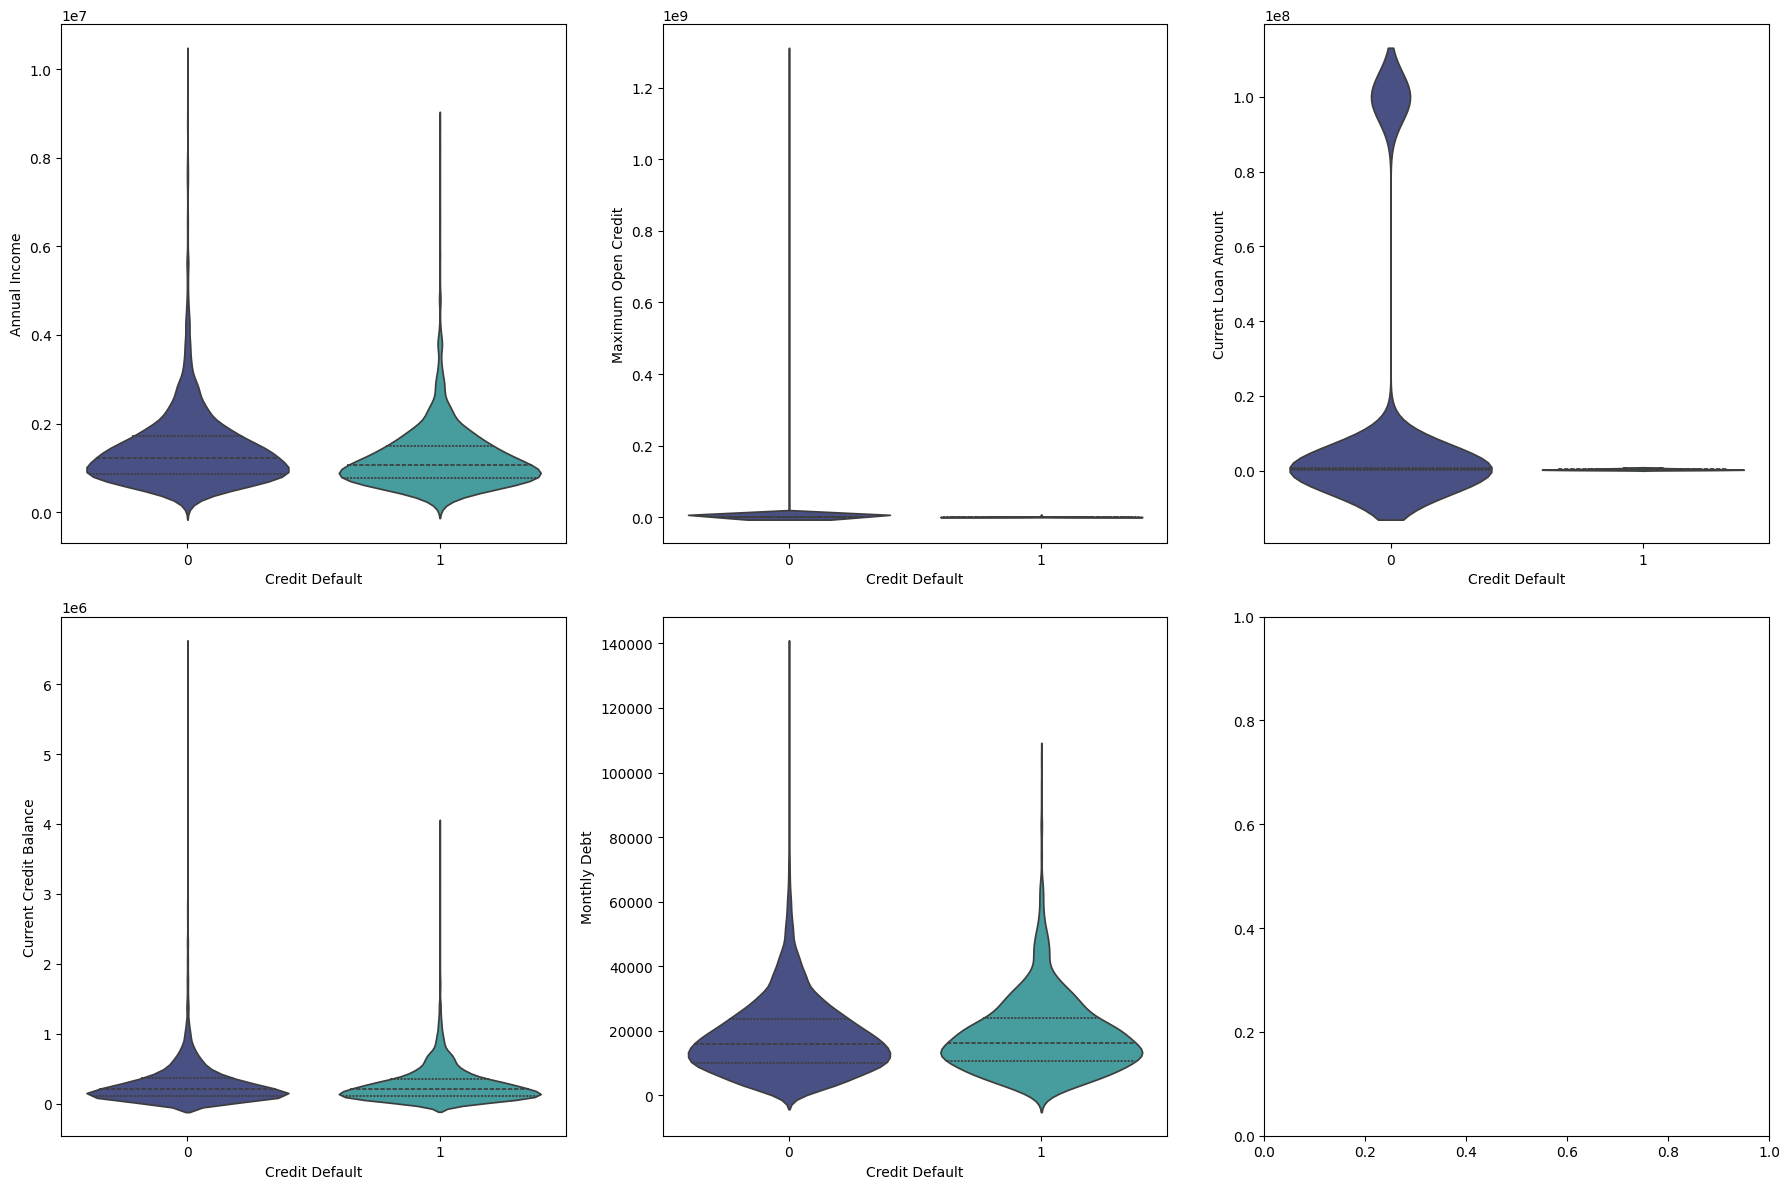

In [ ]:
features_to_plot = ['Annual Income', 'Maximum Open Credit', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(features_to_plot):
    sns.violinplot(data=df, x='Credit Default', y=col, ax=axes[i], palette='mako', inner='quart')

plt.tight_layout()
plt.show()

Видим, что у признаков 'Maximum Open Credit', 'Current Loan Amount' распределение у благонадежных клиентов очень высокое, а у неблагонадежных очень низкое. Это обращает внимание на колоссальный разброс в данных. Моделям сложно находить оптимальные пороговые значения, которые эффективно разделят два класса.

У остальных признаков видим длинные хвосты распределений. Это значит, что основная часть клиентов сосредоточена среди низких значений признака. Но ось Y получается очень растянутой из-за наличия больших величин, хотя их значительно меньше в датасете. Это создает условия для шума и переобучения модели.

Попробуем применить логарифм к финансовым признакам: он растянет низкие значения и спрессует высокие.  Логарифмирование превратит шумный признак в более стабильный предиктор целевой переменной, который поможет модели лучше сфокусироваться на выявлении неблагонадежных заемщиков.



In [ ]:
df['Log_Annual_Income'] = np.log1p(df['Annual Income'])
df['Log_Max_Open_Credit'] = np.log1p(df['Maximum Open Credit'])
df['Log_Current_Loan_Amount'] = np.log1p(df['Current Loan Amount'])
df['Log_Current_Credit_Balance'] = np.log1p(df['Current Credit Balance'])
df['Log_Monthly_Debt'] = np.log1p(df['Monthly Debt'])
df['Log_Credit_Score'] = np.log1p(df['Credit Score'])

При анализе кредитных обязательств важно понять, является ли клиент платежеспособным. Создадим признаки, которые будут характеризовать возможность клиента выполнять обязательства:

*	отношение текущей суммы кредита к ежемесячному доходу;
*	отношение текущей суммы кредита к годовому доходу;
*	отношение ежемесячного долга к ежемесячному доходу.


In [ ]:
df['Solvency_m'] = df['Current Loan Amount'] / (df['Annual Income'] / 12)
df['Solvency_y'] = df['Current Loan Amount'] / df['Annual Income']
df['Solvency_debt'] = df['Monthly Debt'] / (df['Annual Income'] / 12)

Создадим признак, показывающий,  насколько  заемщик исчерпал свой лимит. Высокое использование кредитного лимита может сигнализировать о риске.

In [ ]:
df['Limit'] = (df['Current Credit Balance'] /  (df['Maximum Open Credit'] + 1e-6)).clip(upper=1.0)

 Создадим признаки, характеризующие периодичность открытия счетов и средний долг.

In [ ]:
df['Periodicity'] = df['Number of Open Accounts'] / df['Years of Credit History']
df['Average debt'] = df['Current Credit Balance'] / df['Number of Open Accounts']

Создадим признак, указывающий на очень высокий доход клиента.


In [ ]:
df['Large Income'] = (df['Annual Income'] > df['Annual Income'].quantile(0.75)).astype(int)

Выделим группы проблемных заемщиков:
- одновременно находятся в двух рисковых зонах: с кредитным рейтингом более 5000 и наибольшим открытым кредитом более 200000;
- с длинным сроком кредита и кредитным рейтингом более 5000;
- количеством кредитных проблем или банкротств больше 0.

Также рассчитаем индекс риска, который будет представлять из себя сумму трех показателей риска: кредитный рейтинг больше 5000, длинный срок кредита и наибольший открытый кредит меньше 200000.

In [ ]:
# df['Double_Risk_Zone'] = ((df['Credit Score'] > 5000) & (df['Maximum Open Credit'] < 200000)).astype(int)
# df['Is_Risky_Term'] = ((df['Term'] == 'Long Term') & (df['Credit Score'] > 5000)).astype(int)
# df['Problems'] = ((df['Number of Credit Problems'] > 0) | (df['Bankruptcies'] > 0)).astype(int)

Выделим признаки, свидетельствующие о риске:
- сумма трех показателей риска: кредитный рейтинг больше 5000, длинный срок кредита и наибольший открытый кредит меньше 200000;
- отношения логарифма годового дохода к текущей сумме кредита '+1' для исключения деления на 0;
- индекс отсутствия риска: 10 и более лет  на текущем месте работы и владение домом или ипотека.


In [ ]:
df['Risk_Index'] = (df['Credit Score'] > 5000).astype(int) + (df['Term'] == 'Long Term').astype(int) + (df['Maximum Open Credit'] < 200000).astype(int)
df['New_Risk'] = df['Log_Annual_Income'] / (df['Current Loan Amount'] + 1)
# df['No_Risk'] = ((df['Years in current job'] >= 10) & ((df['Home Ownership'] == 'Mortgage') | (df['Home Ownership'] == 'Own Home'))).astype(int)

Выделим признак баланса ежемесячных доходов и расходов.

In [ ]:
df["Balance"] = (df['Annual Income'] / 12) - df["Monthly Debt"]

Выделим признак отношения текущего кредитного баланса к текущей сумме кредита.

In [ ]:
df['Balance_to_Loan_Ratio'] = df['Current Credit Balance'] / df['Current Loan Amount']

In [ ]:
# df['Is_professional'] = (df['Years in current job'] == 10).astype(int)
# df['Bankruptcy'] = (df['Bankruptcies'] > 0).astype(int)
# df['Problems'] = (df['Number of Credit Problems'] > 0).astype(int)
# df['Is_Hight_Credit_Limit'] = (df['Maximum Open Credit'] > 2000000).astype(int)

Признаки 'Double_Risk_Zone',  'Is_Risky_Term', 'Problems', 'No_Risk', 'Is_professional', 'Bankruptcy', 'Problems', 'Is_Hight_Credit_Limit' не дали прироста к качеству модели, поэтому были исключены из обучения в ходе экспериментов.

Повторно выведем взаимную информацию, чтобы проверить будут ли полезны признаки для обучения.

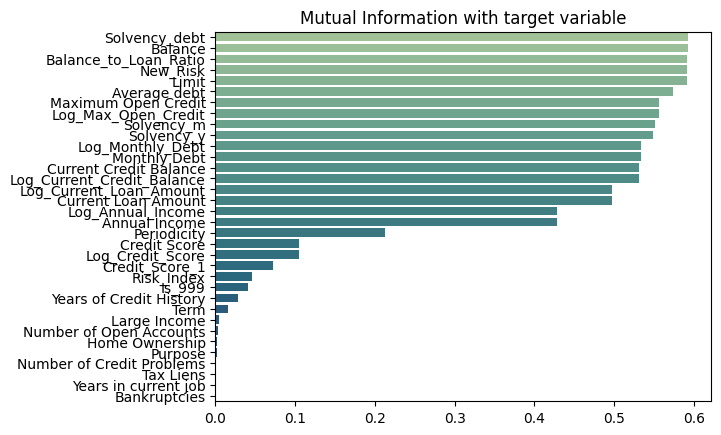

In [ ]:
show_mutual_information(df)

Видим, что новые признаки должны быть полезны для модели.

# Разбиение данных на тренировочные и тестовые

Разделим данные на тренировочные и тестовые, учитывая дисбаланс.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Credit Default', axis=1), df['Credit Default'], test_size=0.3, random_state=42, stratify=df['Credit Default'])

Выделим числовые и индексы категориальных признаков.

In [ ]:
num_cols = X_train.select_dtypes(include=['float64', 'int64']).columns.to_list()
cat_cols_indexes = [i for i, col in enumerate(X_train.columns) if X_train[col].dtype in ['object', 'category']]

Стандартизируем числовые признаки. Категориальные признаки не будем преобразовывать, так как обучение будет производиться при помощи CatBoostClassifier.

In [ ]:
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Обучение и оптимизация моделей

Для обучения будет использоваться алгоритм CatBoostClassifier, так как он хорошо подходит для решаемой задачи: он автоматически и эффективно обрабатывает смешанные типы данных, достаточно устойчив к переобучению благодаря регуляризации, может эффективно работать с несбалансированными данными, показывает высокую точность на табличных данных без необходимости сложного предварительного кодирования категориальных переменных.

## Устранение дисбаланса посредством настроек CatBoostClassifier

Для контроля дисбаланса будем использовать параметр 'auto_class_weights='Balanced'' для автоматического расчета и назначения весов на основе распределения классов. Во время обучения будем отслеживать F1.

In [ ]:
model_catb = catb.CatBoostClassifier(cat_features=cat_cols_indexes, eval_metric='F1', random_state=21, auto_class_weights="Balanced")
model_catb.fit(X_train, y_train)

Learning rate set to 0.020914
0:	learn: 0.6677213	total: 34.5ms	remaining: 34.5s
1:	learn: 0.6481112	total: 53.2ms	remaining: 26.6s
2:	learn: 0.6434926	total: 68.1ms	remaining: 22.6s
3:	learn: 0.6452446	total: 82ms	remaining: 20.4s
4:	learn: 0.6490215	total: 96.6ms	remaining: 19.2s
5:	learn: 0.6500244	total: 111ms	remaining: 18.4s
6:	learn: 0.6503925	total: 129ms	remaining: 18.3s
7:	learn: 0.6502084	total: 143ms	remaining: 17.7s
8:	learn: 0.6504845	total: 161ms	remaining: 17.7s
9:	learn: 0.6502353	total: 174ms	remaining: 17.2s
10:	learn: 0.6502622	total: 187ms	remaining: 16.8s
11:	learn: 0.6504725	total: 204ms	remaining: 16.8s
12:	learn: 0.6504725	total: 217ms	remaining: 16.5s
13:	learn: 0.6520116	total: 230ms	remaining: 16.2s
14:	learn: 0.6534230	total: 243ms	remaining: 16s
15:	learn: 0.6527995	total: 256ms	remaining: 15.7s
16:	learn: 0.6517600	total: 269ms	remaining: 15.6s
17:	learn: 0.6527753	total: 281ms	remaining: 15.3s
18:	learn: 0.6520789	total: 294ms	remaining: 15.2s
19:	learn:

Выполним предсказания и выведем метрики.

In [ ]:
y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)
preds = model_catb.predict_proba(X_test)[:, 1]

In [ ]:
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.96      0.91      0.93      3771
           1       0.79      0.91      0.85      1479

    accuracy                           0.91      5250
   macro avg       0.88      0.91      0.89      5250
weighted avg       0.92      0.91      0.91      5250

TEST

              precision    recall  f1-score   support

           0       0.83      0.79      0.81      1616
           1       0.52      0.58      0.55       634

    accuracy                           0.73      2250
   macro avg       0.68      0.69      0.68      2250
weighted avg       0.74      0.73      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1283  333
1                266  368


На тренировочных данных модель показывает более высокий результат по всем ключевым метрикам F1=0.93 для нулевого класса и F1=0.85 для первого класса. На тестовых данных значения F1 ухудшаются: 0.81 для нулевого класса и 0.55 для первого класса. В целом модель хуже распознает 1 класс.

Чтобы понять, какие признаки модель посчитала важными для обучения, воспользуемся 'feature_importances_'.

In [ ]:
pd.DataFrame(model_catb.feature_importances_,
             X_train.columns,
             columns=['coefficient']).sort_values('coefficient', ascending=False)

,coefficient
Credit Score,7.437151
Balance_to_Loan_Ratio,6.745950
Log_Credit_Score,6.417963
New_Risk,5.774839
Solvency_debt,4.509448
Limit,4.287632
Credit_Score_1,4.083736
Years of Credit History,4.017723
Risk_Index,3.894972
Solvency_m,3.833708


Значимость признаков отличается от взаимной информации. Так, для модели самыми информативным оказался признак Credit Score, по взаимной информации он  расположены в конце списка. Такие ситуации возникают, когда признак может работать как уточняющий фактор для других признаков во время работы классификатора. Признаки, связанные с кредитным рейтингом и платежеспособностью оказались в топе у обоих алгоритмов. Признак Maximum Open Credit по взаимной информации находится в топе, но у  CatBoostClassifier располагается во второй половине списка. Это значит, что признак информативен, но модель не может в полной мере распознать его влияние. В такой ситуации может помочь подбор гиперпараметров.

Признаки 'Term', 'Number of Credit Problems', 'Large Income', 'Bankruptcies', 'Tax Liens' вносят менее 1% важности, попробуем удалить их и заново обучить модель.

In [ ]:
df.drop(['Term', 'Number of Credit Problems', 'Large Income', 'Bankruptcies', 'Tax Liens'], axis=1, inplace=True)

Снова выполним разделение данных и обучение модели.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Credit Default', axis=1), df['Credit Default'], test_size=0.3, random_state=42, stratify=df['Credit Default'])

In [ ]:
num_cols = X_train.select_dtypes(include=['float64', 'int64']).columns.to_list()
cat_cols_indexes = [i for i, col in enumerate(X_train.columns) if X_train[col].dtype in ['object', 'category']]

In [ ]:
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [ ]:
model_catb = catb.CatBoostClassifier(cat_features=cat_cols_indexes, eval_metric='F1', random_state=21, auto_class_weights="Balanced")
model_catb.fit(X_train, y_train)

Learning rate set to 0.020914
0:	learn: 0.6045691	total: 39.9ms	remaining: 39.8s
1:	learn: 0.6626396	total: 73.3ms	remaining: 36.6s
2:	learn: 0.6716201	total: 99.3ms	remaining: 33s
3:	learn: 0.6661699	total: 128ms	remaining: 31.9s
4:	learn: 0.6611307	total: 164ms	remaining: 32.6s
5:	learn: 0.6640962	total: 187ms	remaining: 31s
6:	learn: 0.6609307	total: 216ms	remaining: 30.7s
7:	learn: 0.6632674	total: 240ms	remaining: 29.7s
8:	learn: 0.6624814	total: 262ms	remaining: 28.9s
9:	learn: 0.6592925	total: 284ms	remaining: 28.2s
10:	learn: 0.6596340	total: 320ms	remaining: 28.8s
11:	learn: 0.6599082	total: 346ms	remaining: 28.5s
12:	learn: 0.6588693	total: 375ms	remaining: 28.5s
13:	learn: 0.6592349	total: 407ms	remaining: 28.6s
14:	learn: 0.6597418	total: 439ms	remaining: 28.8s
15:	learn: 0.6616644	total: 468ms	remaining: 28.8s
16:	learn: 0.6633721	total: 500ms	remaining: 28.9s
17:	learn: 0.6638319	total: 526ms	remaining: 28.7s
18:	learn: 0.6627281	total: 565ms	remaining: 29.2s
19:	learn: 0

Выполним предсказания и выведем метрики.

In [ ]:
y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)
preds = model_catb.predict_proba(X_test)[:, 1]

In [ ]:
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.96      0.90      0.93      3771
           1       0.78      0.91      0.84      1479

    accuracy                           0.90      5250
   macro avg       0.87      0.90      0.88      5250
weighted avg       0.91      0.90      0.90      5250

TEST

              precision    recall  f1-score   support

           0       0.83      0.78      0.80      1616
           1       0.51      0.58      0.55       634

    accuracy                           0.73      2250
   macro avg       0.67      0.68      0.67      2250
weighted avg       0.74      0.73      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1264  352
1                264  370


Значения метрик на тренировочных и тестовых данных остались почти без изменений. F1-score снизился до 0.84 для первого класса на тренировочных данных, и до 0.80 для нулевого класса на тестовых данных. Это значит, что удаление признаков вопреки предположениям ведет к небольшому ухудшению метрик.  Попробуем подобрать порог классификации для улучшения результата.

In [ ]:
threshold, fscore, precision, recall = thresholds_search(y_test, preds)
print(f'Best Threshold={threshold}, F-Score={fscore:.3f}, Precision={precision:.3f}, Recall={recall:.3f}')

Best Threshold=0.4837348710121485, F-Score=0.548, Precision=0.497, Recall=0.612


In [ ]:
y_pred_custom = (preds > threshold).astype(int)

In [ ]:
get_classification_report(y_train, y_train_pred, y_test, y_pred_custom)

TRAIN

              precision    recall  f1-score   support

           0       0.96      0.90      0.93      3771
           1       0.78      0.91      0.84      1479

    accuracy                           0.90      5250
   macro avg       0.87      0.90      0.88      5250
weighted avg       0.91      0.90      0.90      5250

TEST

              precision    recall  f1-score   support

           0       0.83      0.76      0.79      1616
           1       0.50      0.61      0.55       634

    accuracy                           0.72      2250
   macro avg       0.66      0.68      0.67      2250
weighted avg       0.74      0.72      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1223  393
1                247  387


Изменение порога привело к небольшому ухудшению до 0.79 f1-score на тестовых данных, и повлияло на recall: на тестовых данных значение снизилось до 0.76 для нулевого класса и увеличилось до 0.61 для первого класса. Это значит, что модель стала чуть хуже отслеживать благонадежных клиентов, но стала выявлять больше неблагонадежных. Выявление клиентов первого класса является для банка более существенным.  

## Устранение дисбаланса при помощи SMOTENC

Сбалансируем классы при помощи SMOTENC, так как датасет содержит количественные и категориальные признаки.

In [ ]:
smote = SMOTENC(
    sampling_strategy=0.7,
    categorical_features=cat_cols_indexes,
    random_state=42,
    k_neighbors=2
)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

Создадим переменную ratio, которая будет содержать значение отношения классов между собой.

In [ ]:
ratio = (y_train_smote == 0).sum() / (y_train_smote == 1).sum()

Проверим количество объектов в каждом классе.

In [ ]:
print(f"Class 0: {sum(y_train_smote == 0)}")
print(f"Class 1: {sum(y_train_smote == 1)}")

Class 0: 3771
Class 1: 2639


Данные готовы для обучения. Обучим модель CatBoostClassifier, передав ей категориальные признаки, scale_pos_weight для обработки дисбаланса.

In [ ]:
model_catb = catb.CatBoostClassifier(cat_features=cat_cols_indexes, scale_pos_weight=ratio, eval_metric='F1', random_state=21)
model_catb.fit(X_train_smote, y_train_smote)

Learning rate set to 0.022775
0:	learn: 0.6515352	total: 87.3ms	remaining: 1m 27s
1:	learn: 0.6478844	total: 133ms	remaining: 1m 6s
2:	learn: 0.6448992	total: 171ms	remaining: 56.9s
3:	learn: 0.6419550	total: 218ms	remaining: 54.2s
4:	learn: 0.6457515	total: 268ms	remaining: 53.3s
5:	learn: 0.6463175	total: 295ms	remaining: 48.9s
6:	learn: 0.6480147	total: 360ms	remaining: 51s
7:	learn: 0.6614527	total: 393ms	remaining: 48.8s
8:	learn: 0.6675324	total: 412ms	remaining: 45.4s
9:	learn: 0.6687493	total: 435ms	remaining: 43s
10:	learn: 0.6676156	total: 468ms	remaining: 42.1s
11:	learn: 0.6731493	total: 505ms	remaining: 41.6s
12:	learn: 0.6722827	total: 526ms	remaining: 39.9s
13:	learn: 0.6724477	total: 547ms	remaining: 38.5s
14:	learn: 0.6707447	total: 570ms	remaining: 37.5s
15:	learn: 0.6720883	total: 600ms	remaining: 36.9s
16:	learn: 0.6713369	total: 630ms	remaining: 36.4s
17:	learn: 0.6707597	total: 662ms	remaining: 36.1s
18:	learn: 0.6690480	total: 686ms	remaining: 35.4s
19:	learn: 0.

Выполним предсказания и выведем метрики.

In [ ]:
y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)
preds = model_catb.predict_proba(X_test)[:, 1]

In [ ]:
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.93      0.94      0.93      3771
           1       0.84      0.81      0.83      1479

    accuracy                           0.90      5250
   macro avg       0.88      0.87      0.88      5250
weighted avg       0.90      0.90      0.90      5250

TEST

              precision    recall  f1-score   support

           0       0.81      0.83      0.82      1616
           1       0.55      0.51      0.53       634

    accuracy                           0.74      2250
   macro avg       0.68      0.67      0.67      2250
weighted avg       0.74      0.74      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1348  268
1                312  322


На тренировочных данных для нулевого класса значения F1 не изменилось, для первого класса стало немного меньше F1= 0.83. На тестовых данных значение F1=0.82 для нулевого класса и F1=0.53 для первого класса. Результаты сопоставимы с предыдущей моделью, в целом первый класс снова распознается хуже. Попробуем подобрать порог классификации для улучшения результата.

In [ ]:
threshold, fscore, precision, recall = thresholds_search(y_test, preds)
print(f'Best Threshold={threshold}, F-Score={fscore:.3f}, Precision={precision:.3f}, Recall={recall:.3f}')

Best Threshold=0.4102150085792137, F-Score=0.547, Precision=0.477, Recall=0.640


In [ ]:
y_pred_custom = (preds > threshold).astype(int)

In [ ]:
get_classification_report(y_train, y_train_pred, y_test, y_pred_custom)

TRAIN

              precision    recall  f1-score   support

           0       0.93      0.94      0.93      3771
           1       0.84      0.81      0.83      1479

    accuracy                           0.90      5250
   macro avg       0.88      0.87      0.88      5250
weighted avg       0.90      0.90      0.90      5250

TEST

              precision    recall  f1-score   support

           0       0.84      0.72      0.78      1616
           1       0.48      0.64      0.55       634

    accuracy                           0.70      2250
   macro avg       0.66      0.68      0.66      2250
weighted avg       0.74      0.70      0.71      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1171  445
1                229  405



С подобранным порогом значения метрик на тестовых данных для первого класса улучшились:  F1=0.55. Вырос recall=0.64. Это значит, что модель распознает с таким порогом больше примеров первого класса. Видим, что SMOTENC не привел к значительному улучшению метрик. Возможно, причина в том, что используемый датасет не подходит для метода ближайших соседей.  Возможно, синтетические признаки дублируют слишком много неопределенности оригинальных переменных, создавая шум, из которого модель не может извлечь полезную информацию.

Таким образом, на тестовых данных наилучшее качество показал первый вариант модели с максимальным количеством признаков, с f1-score=0.81 для нулевого класса и f1-score=0.55 для первого класса.


## Подбор параметров при помощи RandomizedSearchCV

Попробуем подобрать параметры лучшей модели при помощи RandomizedSearchCV, чтобы улучшить качество обучения. 1	Определим пространство поиска гиперпараметров.

In [ ]:
params_cb = {'iterations': [300, 500, 1000],
             'depth': [4, 6, 8, 10],
             'learning_rate':[0.001, 0.01, 0.05, 0.1],
             'l2_leaf_reg': [1, 5, 7, 10, 12],
             'border_count': [32, 64, 128],
             'min_data_in_leaf': [1, 5, 10, 15, 20],
             'random_strength': [0.5, 0.7, 0.9, 1],
             'bagging_temperature': [0, 1],
             'colsample_bylevel': [0.5, 0.7, 0.9, 1]
             }

Будем использовать K-fold для надёжной оценки производительности каждой комбинации.

In [ ]:
cv=KFold(n_splits=3, random_state=42, shuffle=True)

Запустим поиск.

In [ ]:
%%time

cb = RandomizedSearchCV(model_catb, params_cb, scoring='f1', cv=cv, n_jobs=-1)
cb.fit(X_train, y_train)

0:	learn: 0.6169795	total: 20.5ms	remaining: 6.14s
1:	learn: 0.6408051	total: 37.5ms	remaining: 5.59s
2:	learn: 0.6454897	total: 55.3ms	remaining: 5.47s
3:	learn: 0.6458604	total: 71.7ms	remaining: 5.3s
4:	learn: 0.6470359	total: 91ms	remaining: 5.37s
5:	learn: 0.6493420	total: 108ms	remaining: 5.27s
6:	learn: 0.6482080	total: 116ms	remaining: 4.86s
7:	learn: 0.6482761	total: 131ms	remaining: 4.78s
8:	learn: 0.6477207	total: 147ms	remaining: 4.75s
9:	learn: 0.6498252	total: 163ms	remaining: 4.72s
10:	learn: 0.6529733	total: 178ms	remaining: 4.68s
11:	learn: 0.6519622	total: 193ms	remaining: 4.64s
12:	learn: 0.6543554	total: 208ms	remaining: 4.59s
13:	learn: 0.6526679	total: 230ms	remaining: 4.69s
14:	learn: 0.6505188	total: 247ms	remaining: 4.69s
15:	learn: 0.6545916	total: 263ms	remaining: 4.67s
16:	learn: 0.6533941	total: 280ms	remaining: 4.67s
17:	learn: 0.6533461	total: 296ms	remaining: 4.64s
18:	learn: 0.6531578	total: 313ms	remaining: 4.63s
19:	learn: 0.6516459	total: 327ms	remai

RandomizedSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x7a12496ae8a0>,
                   n_jobs=-1,
                   param_distributions={'bagging_temperature': [0, 1],
                                        'border_count': [32, 64, 128],
                                        'colsample_bylevel': [0.5, 0.7, 0.9, 1],
                                        'depth': [4, 6, 8, 10],
                                        'iterations': [300, 500, 1000],
                                        'l2_leaf_reg': [1, 5, 7, 10, 12],
                                        'learning_rate': [0.001, 0.01, 0.05,
                                                          0.1],
                                        'min_data_in_leaf': [1, 5, 10, 15, 20],
                                        'random_strength': [0.5, 0.7, 0.9, 1]},
                   scoring='f1')

Выведем наилучшие параметры.

In [ ]:
params = cb.best_params_
params

{'random_strength': 0.5,
 'min_data_in_leaf': 15,
 'learning_rate': 0.01,
 'l2_leaf_reg': 1,
 'iterations': 300,
 'depth': 6,
 'colsample_bylevel': 1,
 'border_count': 32,
 'bagging_temperature': 0}

Обучим с ними модель.

In [ ]:
final_cb = catb.CatBoostClassifier(**params,
                                   cat_features=cat_cols_indexes,
                                   eval_metric='F1',
                                   auto_class_weights="Balanced",
                                   silent=True,
                                   random_state=21)
final_cb.fit(X_train, y_train)

In [ ]:
y_train_pred = final_cb.predict(X_train)
y_test_pred = final_cb.predict(X_test)
preds = final_cb.predict_proba(X_test)[:, 1]

Выполним предсказания.

In [ ]:
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.77      0.82      3771
           1       0.55      0.73      0.63      1479

    accuracy                           0.76      5250
   macro avg       0.71      0.75      0.72      5250
weighted avg       0.79      0.76      0.77      5250

TEST

              precision    recall  f1-score   support

           0       0.84      0.73      0.78      1616
           1       0.48      0.64      0.55       634

    accuracy                           0.70      2250
   macro avg       0.66      0.68      0.66      2250
weighted avg       0.74      0.70      0.71      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1174  442
1                230  404


Подбор гиперпараметров не смог улучшить f1-score. Таким образом, наилучший f1-score на тестовых данных показала первая модель:  0.81       для нулевого класса и 0.55        для первого класса. Однако, последняя модель менее склонна к переобучению, и показывает лучший recall на тестовых данных: 0.73 для нулевого класса и 0.64 для первого класса. Это значит, что модель находит больше неблагонадежных клиентов, что является целью банка. По матрице ошибок видим, что модель правильно распознала 404 неблагонадежных клиента (ранее 368).



# Вывод


В процессе исследования было выполнено следующее:
- Проведен разведочный анализ данных.
- Выполнен статистический анализ признака Credit Score в разрезе целевой переменной. Подтверждена гипотеза о существовании различий между распределениями кредитного рейтинга между благонадежными и неблагонадежными заемщиками.
- Реализовано обучение модели CatBoostClassifier.
- В ходе исследования была выявлена проблема дисбаланса классов. Проработано два варианта балансировки выборки:
  - Встроенные параметры CatBoostClassifier.
  - Алгоритм SMOTENC.

CatBoostClassifier лучше самостоятельно справился с дисбалансом, чем при использовании SMOTENC, хотя оба подхода дают схожую F1-меру на одних и тех же данных с одинаковыми параметрами обучения.
-  Был осуществлен подбор гиперпараметров модели при помощи RandomizedSearchCV, но он не смог улучить метрику.
- Итоговая модель имеет F1 = 0.81 для нулевого класса и F1 = 0.55 для первого класса.

Подводя итог, можно сделать вывод, что кредитный скоринг — одна из самых сложных областей для прогнозирования из-за высокой степени неопределенности человеческого поведения, сильной несбалансированности классов и множества скрытых факторов, не отраженных в данных. Полученные значения F1-score являются закономерными для этой области данных, так как человеческое поведение содержит существенную долю непредсказуемости. Высокие значения F1 в кредитном скоринге могли бы свидетельствовать об утечке данных или переобучении, поскольку обстоятельства неоплаты не отражаются в исторических кредитных данных, что естественно ограничивает максимально достижимую точность прогнозов. В исследуемом датасете отсутствуют личностные признаки, такие как возраст, пол, профессия, семейное положение и т. д., которые существенно влияют на финансовое поведение. Это является фундаментальным ограничением рассматриваемых данных, и создаёт разрыв между формальными кредитными показателями и реальными обстоятельствами, когда два заёмщика с похожими значениями признаков могут демонстрировать разную благонадежность, что объективно устанавливает пределы точности даже для самых совершенных алгоритмов.